# Datascience module version
Like any other 'maintained' package, the datascience package is constantly revised. 

Version 0.17.6 had some changes to the API, which breaks some of the examples. We therefore need to make sure we are using a version smaller than 0.17.6 and might have to downgrade to version 0.17.5. 

We do this by 'escaping' jupyter and run the python package manager "pip" from the 'shell'. 

We run the command:

`!pip install --user datascience==0.17.5`

The command installs a specific version (0.17.5) of datascience in user space.

Afterwards, we have to restart the kernel and then can verify the version of datascience we are using with

```python
import datascience
datascience.__version__
````

In [1]:
!pip install --user datascience==0.17.5

ERROR: Can not perform a '--user' install. User site-packages are not visible in this virtualenv.


In [2]:
import datascience
datascience.__version__

'0.17.5'

In [3]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Comparing Two Samples
- read in the 'data/baby.csv' file
- look at the data
- subset to `Birth Weight` and `Maternal Smoker` columns
- How many babies are in the smoker and the nonsmoker group?
- Make a histogram showing the weight distribution of babies
- Make a histogram with the distribution of the smoker babies and the non-smoker babies

In [4]:
births = Table.read_table('data/baby.csv')

In [5]:
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [6]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')

In [7]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


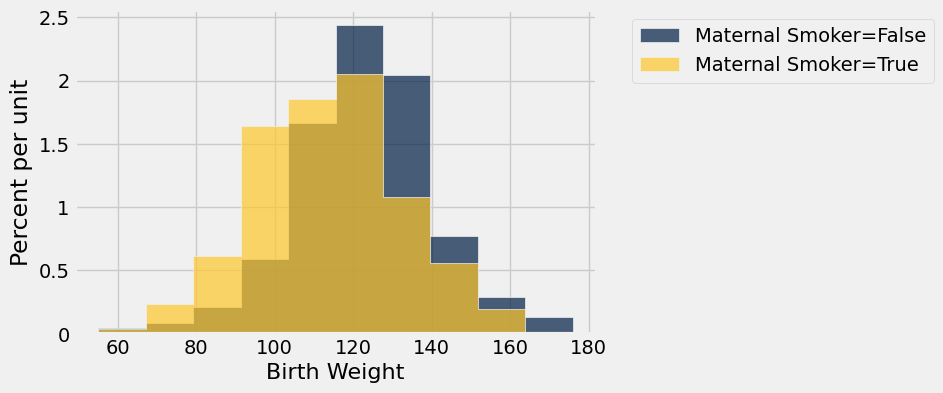

In [8]:
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

--- 

back to slides

---

# Test Statistic

**Question**: What values of our statistic are in favor of the alternative: positive or negative?

- compute the average birthweights of smokers and nonsmokers
- compute the difference between the two groups
- create a function that accepts 
    - a `table`, a `group label`, and a `variable label` and
    - computes the difference in the average of the variable in the two groups

In [10]:
means = means_table.column('Birth Weight average')
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

In [11]:
def difference_of_means(table, label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups"""
    
    #table with the two relevant columns
    reduced = table.select(label, group_label)  
    
    # table containing group means
    means_table = reduced.group(group_label, np.average)
    # array of group means
    means = means_table.column(1)
    
    return means.item(1) - means.item(0)

In [12]:
difference_of_means(births, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

In [9]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


---
back to slides

----

# Random Permutation (Shuffling)
- remember the [sample function](http://www.data8.org/datascience/reference-nb/datascience-reference.html#tbl.sample())
- by sampling with replacement, we can shuffle the order of a column
- shuffle the table and attach the shuffled `Letter` as a new column

In [13]:
letters = Table().with_column('Letter', make_array('a', 'b', 'c', 'd', 'e'))

In [14]:
letters.sample()

Letter
d
e
e
d
c


In [15]:
letters.sample(with_replacement = False)

Letter
a
c
d
b
e


In [16]:
letters.with_column('Shuffled', letters.sample(with_replacement = False).column(0))

Letter,Shuffled
a,a
b,d
c,c
d,b
e,e


# Simulation Under Null Hypothesis
- Shuffle the smoking/nonsmoking labels
- attach the shuffled labels to the `smoking_and_birthweight` table
- calculate the difference of means for the original labels
- calculate the difference of means for the shuffled labels

In [17]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [18]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement=False).column('Maternal Smoker')

In [19]:
original_and_shuffled = smoking_and_birthweight.with_column('Shuffled Label', shuffled_labels)

In [20]:
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,True
False,113,False
True,128,False
True,108,True
False,136,True
False,138,False
False,132,False
False,120,True
True,143,False
False,140,False


In [21]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Shuffled Label')

-0.07260843731431521

In [22]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

# Permutation Test
- create a function that shuffles the labels and calculates the difference of means
- simulate 2500 times. This should yield an array with 2500 differences
- create a table and plot the histogram

In [23]:
def one_simulated_difference(table, label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = table.sample(with_replacement = False).column(group_label)
    
    # table of numerical variable and shuffled labels
    shuffled_table = table.select(label).with_column('Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, label, 'Shuffled Label')   

In [24]:
one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')

1.9378064201593617

In [25]:
differences = make_array()

for i in np.arange(2500):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
    differences = np.append(differences, new_difference)

Observed Difference: -9.266142572024918


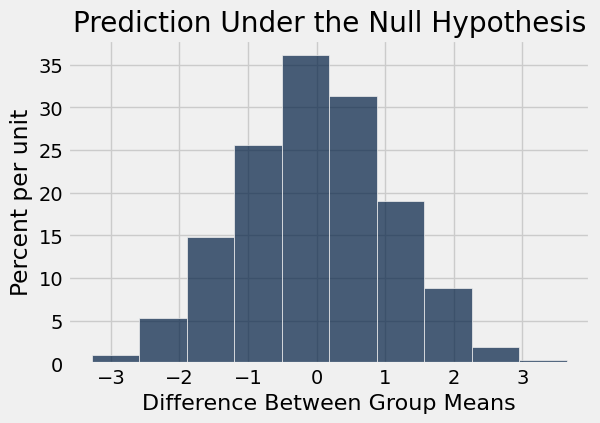

In [26]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');